# Global Sensitivity Analysis (GSA) using Sobol's Method for mathematical model of microglia metabolism, lactylation and inflammation.

# ODE Model for Metabolites and Lactylation in Microglia
System of equations (glucose, pyruvate, lactate and inflammation):
$$\frac{dG}{dt}=\Lambda(I) (G_E-G) -\frac{V_{P}G}{K_P +G}h^+_{1}(L)$$
$$\frac{dP}{dt}=\frac{V_{P}G}{K_P +G}h^+_{1}(L) -\Delta(I)\frac{V_{L}P}{K_L + P}h^+_{2}(L)-(1-\Delta(I))\frac{V_{T}P}{K_T + P}$$
$$\frac{dL}{dt}=\Delta(I)\frac{V_{L}P}{K_L + P}h^+_{2}(L) + \Sigma(I)(L_E-L)$$
$$\frac{dI}{dt}=\frac{a_{LI}L}{b_{LI}+L}-d_II$$
Where
$$ \Lambda(I) = \frac{a_{IG}I }{b_{IG} + I} + \lambda$$
$$\Sigma(I) = \frac{a_{IL}I  }{b_{IL} + I}+\sigma$$
$$ \Delta(I) = \frac{a_{IL}I}{b_{IL} + I}+\delta$$
$$h^+_{1}(L) = H_1 + \frac{a_{LG}L}{b_{LG}+L}$$
$$h^+_{2}(L) = H_2 + \frac{a_{LP}L}{b_{LP}+L}$$
which represent inflammation's upregulation of glycoloysis and lactate production and lactate's upregulation of enzymes PKM2 and LDHA (through histone lactylation).
All parameters are greater than or equal to zero, and there is a further constraint that $1-\Delta(I) \geq 0$.

Note: SALIb can be installed from the terminal with conda install -c conda-forge salib.


## Uses nonstiff ODE Solver

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from SALib.sample import saltelli
from SALib.analyze import sobol
# to plot multiple plots
import pylab
import time
import random
import matplotlib.pyplot as plt


## Plot Solution for One Parameter Set

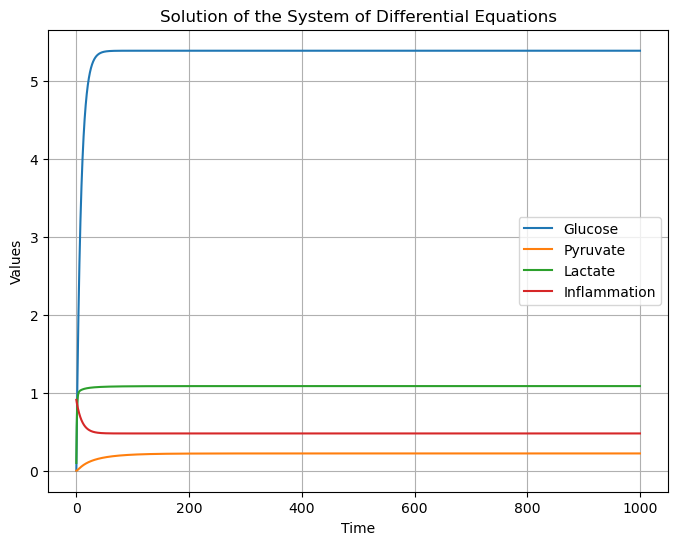

In [2]:
def f(y,t,paras):
    G = y[0]
    P = y[1]
    L = y[2]
    I = y[3]

# build a few functions for short hand
    # inflammation upregulates processes
    lambdafunction =(lambda1 + aIG * I/(bIG + I)) # when I = 0, this is the constant lambda1
    deltafunction = delta + aIP * I/(bIP + I) # when I = 0, this is constant delta
    sigmafunction = sigma + aIL * I/(bIL + I) # when I = 0, this is constant sigma
    # lacate upregulates processes with epigenetic regulation
    h1 = H1 + aLG * L/(bLG + L) # increases glucose to pyruvate flux, function of lactate
    h2 = H2 + aLP * L/(bLP + L) # increaes pyruvate to lactate flux, function of lactate
    inflam = aLI * L/(bLI + L) # lactate increase inflammation
    
    
    f0 = lambdafunction * (GE - G) -  (VP * G)/(KP + G) * h1
    f1 = (VP * G)/(KP + G) * h1 - deltafunction * (VL * P)/(KL + P) * h2 - (1-deltafunction) * (VT * P)/(KT + P)
    f2 = deltafunction * (VL * P)/(KL + P) - sigmafunction * (L - LE)
    f3 = inflam - dI * I # exponential decay
    
    return [f0, f1, f2, f3]

# initial conditions
G0 = 0  # initial glucose
P0 = 0  # initial pyruvate
L0 = .1  # initial lactate
I0 = .909  # initial inflammation

y0 = [G0, P0, L0, I0] # initial condition vector
t = np.linspace(0,1000,100000) # time grid, 0 to 1000 in 100000 steps


# baseline parameter values
lambda1 = .0755 # glucose import 
GE = 5.5 # external glucose
VP = .123 # glucose to pyruvate
KP = 1.7 #glucose to pyruvate
delta = .95 # proportion of pyruvate sent to lactate, 0<=delta<=1
VL = .14 # pyruvte to lactate
KL = .125 # pyruvte to lactate
VT = .15 # pyruvate to TCA
KT = .02 # pyruvate to TCA
sigma = 1 # lactate export
LE = 1 # external lactate

# inflammation parameters
aLI = .05
bLI = .05
dI = .1

# feeback pieces
# convention: subscript IG means inflammation's influence on glucose

# inflammation influence
aIG = .05
bIG = .05
aIP = .05
bIP = .05
aIL = .05 # inflammation influence pyruvate to lactate flux and lactate export
bIL = .05 

# lactate influence
aLG = .05 
bLG = .05
H1 = .1
aLP = .05 
bLP = .05
H2 = .1

# Define parameters
params = (lambda1, GE, VP, KP, delta, VL, KL, VT, KT, sigma, LE, aLI, bLI, dI, aIG, bIG, aIP, bIP, 
          aIL, bIL, aLG, bLG, H1, aLP, bLP, H2)

soln = odeint(f, y0, t, args=(params,))

# Plot the solution
plt.figure(figsize=(8, 6))
plt.plot(t, soln)
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Solution of the System of Differential Equations')
plt.legend(['Glucose', 'Pyruvate', 'Lactate', 'Inflammation'])
plt.grid(True)
plt.show()


## Solve ODE for fixed parameters and initial conditions

In [3]:
def f(y, t, paras):

    G = y[0]
    P = y[1]
    L = y[2]
    I = y[3]

    

    try:
        # 26 parameter values
        lambda1 = paras['lambda1'].value
        GE = paras['GE'].value
        VP = paras['VP'].value
        KP = paras['KP'].value
        delta = paras['delta'].value
        VL = paras['VL'].value
        KL = paras['KL'].value
        VT = paras['VT'].value
        KT = paras['KT'].value
        sigma = paras['sigma'].value
        LE = paras['LE'].value
        aLI = paras['aLI'].value
        bLI = paras['bLI'].value
        dI = paras['dI'].value 
        aIG = paras['aIG'].value 
        bIG = paras['bIG'].value
        aIP = paras['aIP'].value
        bIP = paras['bIP'].value
        aIL = paras['aIL'].value
        bIL = paras['bIL'].value
        aLG = paras['aLG'].value
        bLG = paras['bLG'].value
        H1 = paras['H1'].value
        aLP = paras['aLP'].value
        bLP = paras['bLP'].value
        H2 = paras['H2'].value
        
       
        

    except:
        lambda1, GE, VP, KP, delta, VL, KL, VT, KT, sigma, LE, aLI, bLI, dI, aIG, bIG, aIP, bIP, aIL, bIL, aLG, bLG, H1, aLP, bLP, H2 = paras
    
    # the model equations 
    # build a few functions for short hand
    # inflammation upregulates processes
    lambdafunction =(lambda1 + aIG * I/(bIG + I)) # when I = 0, this is the constant lambda1
    deltafunction = delta + aIP * I/(bIP + I) # when I = 0, this is constant delta
    sigmafunction = sigma + aIL * I/(bIL + I) # when I = 0, this is constant sigma
    # lacate upregulates processes with epigenetic regulation
    h1 = H1 + aLG * L/(bLG + L) # increases glucose to pyruvate flux, function of lactate
    h2 = H2 + aLP * L/(bLP + L) # increaes pyruvate to lactate flux, function of lactate
    inflam = aLI * L/(bLI + L) # lactate increase inflammation
    
    
    f0 = lambdafunction * (GE - G) -  (VP * G)/(KP + G) * h1
    f1 = (VP * G)/(KP + G) * h1 - deltafunction * (VL * P)/(KL + P) * h2 - (1-deltafunction) * (VT * P)/(KT + P)
    f2 = deltafunction * (VL * P)/(KL + P) - sigmafunction * (L - LE)
    f3 = inflam - dI * I # exponential decay
    return [f0, f1, f2, f3]

# initial conditions
G0 = 0  # initial glucose
P0 = 0  # initial pyruvate
L0 = .1  # initial lactate
I0 = .909  # initial inflammation

y0 = [G0, P0, L0, I0] # initial condition vector
t = np.linspace(0,1000,100000) # time grid, 0 to 1000 in 100000 steps

# baseline parameter values.  
# baseline parameter values
lambda1 = .0755 # glucose import 
GE = 5.5 # external glucose
VP = .123 # glucose to pyruvate
KP = 1.7 #glucose to pyruvate
delta = .95 # proportion of pyruvate sent to lactate, 0<=delta<=1
VL = .14 # pyruvte to lactate
KL = .125 # pyruvte to lactate
VT = .15 # pyruvate to TCA
KT = .02 # pyruvate to TCA
sigma = 1 # lactate export
LE = 1 # external lactate

# inflammation parameters
aLI = .05
bLI = .05
dI = .1

# feeback pieces
# convention: subscript IG means inflammation's influence on glucose

# inflammation influence
aIG = .05
bIG = .05 
aIP = .05
bIP = .05
aIL = .05 # inflammation influence pyruvate to lactate flux and lactate export
bIL = .05 

# lactate influence
aLG = .05 
bLG = .05
H1 = .1
aLP = .05 
bLP = .05
H2 = .1

### GSA

In [4]:
# 26 parameters are lambda1, GE, VP, KP, delta, VL, KL, VT, KT, sigma, LE, aLI, bLI, dI, aIG, bIG, aIP, bIP, 
          # aIL, bIL, aLG, bLG, H1, aLP, bLP, H2
    
# vary parameters an order of magnitude in each direction of baseline value 
vl =.1
vr = 10   
    
problem = {
    'num_vars': 26, # number of parameters
    'names': ['lambda1', 'GE', 'VP', 'KP', 'delta', 'VL', 'KL', 'VT', 'KT', 'sigma', 'LE', 'aLI', 'bLI', 'dI',
              'aIG', 'bIG', 'aIP', 'bIP', 'aIL', 'bIL', 'aLG', 'bLG', 'H1', 'aLP', 'bLP', 'H2'],
    'bounds': [[vl*lambda1, vr*lambda1],  
               [vl*GE, vr*GE],  
               [vl*VP, vr*VP],  
               [vl*KP, vr*KP],
               [vl*delta, vr*delta],
               [vl*VL, vr*VL],
               [vl*KL, vr*KL],
               [vl*VT, vr*VT],
               [vl*KT, vr*KT],
               [vl*sigma, vr*sigma],
               [vl*LE, vr*LE],
               [vl*aLI, vr*aLI],
               [vl*bLI, vr*bLI],
               [vl*dI, vr*dI],
               [vl*aIG, vr*aIG],
               [vl*bIG, vr*bIG],
               [vl*aIP, vr*aIP],
               [vl*bIP, vr*bIP],
               [vl*aIL, vr*aIL], 
               [vl*bIL, vr*bIL], 
               [vl*aLG, vr*aLG],
               [vl*bLG, vr*bLG], 
               [vl*H1, vr*H1], 
               [vl*aLP, vr*aLP],
               [vl*bLP, vr*bLP], 
               [vl*H2, vr*H2]]         
}

# generate samples
param_values = saltelli.sample(problem, 16384) # second argument is related to the number of samples to take, samples are put in rows, one column for each parameter.  


Ygluc = np.zeros([param_values.shape[0]]) # make array to hold outcome of interest 
Ypyruv = np.zeros([param_values.shape[0]])
Ylactate = np.zeros([param_values.shape[0]])
Yinflam = np.zeros([param_values.shape[0]])
#print(Ygluc.shape)

for i in range(param_values.shape[0]):
   
  # solve the ODEs
  # set parameter values based on sample
  # 26 parameters are lambda1, GE, VP, KP, delta, VL, KL, VT, KT, sigma, LE, aLI, bLI, dI, aIG, bIG, aIP, bIP, 
          # aIL, bIL, aLG, bLG, H1, aLP, bLP, H2


    lambda1_val = param_values[i,0]
    GE_val = param_values[i,1]
    VP_val = param_values[i,2]
    KP_val = param_values[i,3]
    delta_val = param_values[i,4]
    VL_val = param_values[i,5]
    KL_val = param_values[i,6]
    VT_val = param_values[i,7]
    KT_val = param_values[i,8]
    sigma_val = param_values[i,9]
    LE_val = param_values[i,10]
    aLI_val = param_values[i,11]
    bLI_val = param_values[i,12]
    dI_val = param_values[i,13]
    aIG_val = param_values[i,14]
    bIG_val = param_values[i,15]
    aIP_val = param_values[i,16]
    bIP_val = param_values[i,17]
    aIL_val = param_values[i,18]
    bIL_val = param_values[i,19]
    aLG_val = param_values[i,20]
    bLG_val = param_values[i,21]
    H1_val = param_values[i,22]
    aLP_val = param_values[i,23]
    bLP_val = param_values[i,24]
    H2_val = param_values[i,25]

    # define parameters to pass to ode solver
    params = (lambda1_val, GE_val, VP_val, KP_val, delta_val, VL_val, KL_val, VT_val, KT_val, sigma_val, LE_val,
              aLI_val, bLI_val, dI_val, aIG_val, bIG_val, aIP_val, bIP_val, aIL_val, bIL_val, aLG_val, bLG_val,
              H1_val, aLP_val, bLP_val, H2_val)
    
    soln = odeint(f, y0, t, args=(params,))     # solve system of ODE

    # extract each state variable, and store solution in its own matrix
    G = soln[:, 0]
    P = soln[:, 1]
    L = soln[:, 2]
    I = soln[:, 3]
    

    # the last time step (since we have reached steady state) is the outcome of interest-- start with glucose
    # outcome of interest  at last time step (at steady state)
    
  
    
    # modify from Y[i] so we can do analysis for all variables with one run
    Ygluc[i] = G[-1]
    Ypyruv[i] = P[-1]
    Ylactate[i] = L[-1]
    Yinflam[i] = I[-1]
    


/var/folders/ys/8cjlgkyj0qn502jgcn5krqz80000gq/T/ipykernel_79553/2277473460.py:41: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, 16384) # second argument is related to the number of samples to take, samples are put in rows, one column for each parameter.


## Perform Analysis for Glucose

In [5]:
# perform analysis
# sobol.analyze will compute first, second, and total-order indices.
# Si is a Python dictionary with the keys "S1", "S2", "ST", "S1_conf", "S2_conf", and "ST_conf

Si_glucose = sobol.analyze(problem, Ygluc)
# see results on console for 1st order and total sensitivities
print(Si_glucose['S1'])  
print(Si_glucose['ST'])

[ 1.33649616e-03  9.93632710e-01  7.01977935e-04  2.26102463e-04
 -1.86245306e-06  2.40766431e-06 -4.00978944e-07 -1.67635844e-06
  1.81070919e-07 -4.37656712e-06  4.38384393e-07 -1.16530944e-04
  4.51512144e-06 -7.27890179e-05  4.94356338e-04 -3.08062940e-05
 -1.50766132e-07 -9.75220067e-09  5.39153440e-08  1.18061358e-07
  8.18100061e-05  5.92976839e-06 -2.27734724e-04  1.80536500e-07
  1.52184926e-09 -1.91905709e-06]
[3.82414119e-03 9.94532048e-01 2.10325341e-03 2.17621762e-04
 1.79835995e-07 1.31020712e-07 2.18913812e-08 1.13138824e-07
 6.47352377e-09 2.32450596e-07 3.05681183e-06 4.54384905e-04
 7.04013484e-07 1.71611311e-04 1.54198242e-03 2.25032674e-04
 2.44002386e-10 7.12950810e-11 5.91246701e-10 1.01725047e-10
 2.63050629e-04 1.67712425e-06 1.01642208e-03 1.05963435e-08
 1.07866853e-09 3.27123770e-08]


### Plot Graph of First Order and Total Sensitivity Indices

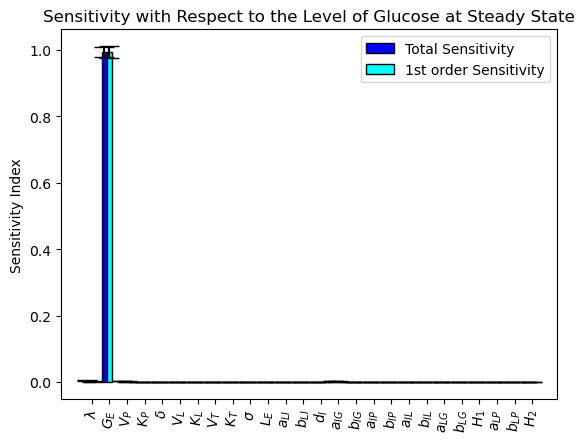

In [6]:
 # Si.get('S1') # returns array with values for S1    
A = Si_glucose.get('S1')
# change array to list for plotting
S1_values = A.tolist() # list of S1 values
# get ST values
B = Si_glucose.get('ST')
# change array to list for plotting
ST_values = B.tolist()
 # get confidence intervals for ST
C = Si_glucose.get('ST_conf')
# change array to list for plotting
STconf_values = C.tolist()
# get confidence intervals for S1
D = Si_glucose.get('S1_conf')
# change array to list for plotting
S1conf_values = D.tolist()
 
 # width of the bars
barWidth = 0.3
 
# Choose the height of the blue bars-- ST
bars1 = ST_values
 
# Choose the height of the cyan bars-- S1
bars2 = S1_values
 
# Choose the height of the error bars (bars1)-- CI for ST
yer1 = STconf_values
# Choose the height of the error bars (bars2)-- CI for S1
yer2 = S1conf_values
 
# The x position of bars
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

f = plt.figure()
 
# Create blue bars
plt.bar(r1, bars1, width = barWidth, color = 'blue', edgecolor = 'black', yerr=yer1, capsize=7, label='Total Sensitivity')
 
# Create cyan bars
plt.bar(r2, bars2, width = barWidth, color = 'cyan', edgecolor = 'black', yerr=yer2, capsize=7, label='1st order Sensitivity')
 
## general layout

plt.xticks([r + barWidth for r in range(len(bars1))], ['$\lambda$', '$G_E$', '$V_P$', '$K_P$', '$\delta$', '$V_L$', '$K_L$',
                                                       '$V_T$', '$K_T$', '$\sigma$', '$L_E$', '$a_{LI}$', '$b_{LI}$', '$d_I$',
                                                       '$a_{IG}$', '$b_{IG}$', '$a_{IP}$', '$b_{IP}$', '$a_{IL}$', '$b_{IL}$', '$a_{LG}$', '$b_{LG}$',
                                                       '$H_1$', '$a_{LP}$', '$b_{LP}$', '$H_2$'],rotation='vertical')

plt.ylabel('Sensitivity Index')
plt.legend()
plt.title('Sensitivity with Respect to the Level of Glucose at Steady State') 


# view and save figure (saving will allow you to put into your paper)
plt.show()


In [7]:
f.savefig("GSAmicrogliaGlucose10-24.pdf") 

### Perform Analysis for Pyruvate

In [8]:
# perform analysis
# sobol.analyze will compute first, second, and total-order indices.
# Si is a Python dictionary with the keys "S1", "S2", "ST", "S1_conf", "S2_conf", and "ST_conf

Si_pyruvate = sobol.analyze(problem, Ypyruv)
# see results on console for 1st order and total sensitivities
print(Si_pyruvate['S1'])  
print(Si_pyruvate['ST'])

[-4.66461616e-05  3.07807222e-04  3.99203861e-03  2.64353910e-04
  1.97024901e-01  1.52877683e-01  1.12085749e-03  2.69717604e-01
  3.70505843e-04 -5.79918335e-05  9.92075932e-06  4.17186378e-05
  9.19531460e-06 -1.03905177e-04 -4.28536339e-05 -6.33893982e-06
  2.04054793e-04  3.47985729e-05  2.59767361e-06  6.29753880e-07
  2.64920946e-04 -4.68815172e-05  9.55302399e-04  1.15735968e-02
  2.16829428e-04  5.32814388e-02]
[1.74864493e-05 1.65628181e-03 7.13782313e-03 1.04381209e-03
 4.32353843e-01 3.10089326e-01 5.82743611e-03 5.04809927e-01
 3.10006197e-03 4.28007767e-05 2.59010397e-04 1.30342671e-04
 6.23396004e-07 8.61508574e-05 7.09439002e-06 5.39985812e-07
 5.58294377e-04 9.14587524e-05 1.00115946e-07 1.66592197e-08
 1.15448672e-03 5.01817519e-06 3.92852435e-03 3.53891474e-02
 4.13479673e-04 1.31609696e-01]


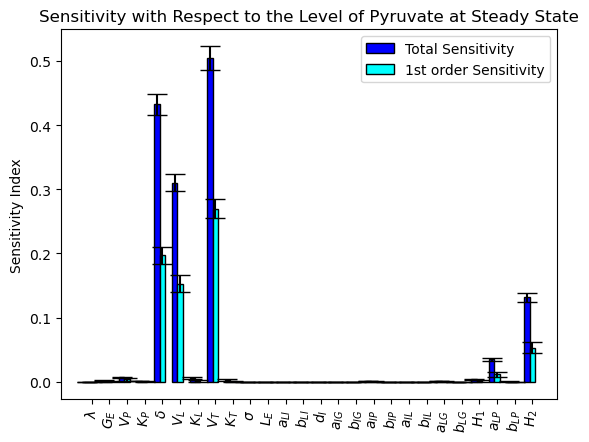

In [9]:
 # Si.get('S1') # returns array with values for S1    
A = Si_pyruvate.get('S1')
# change array to list for plotting
S1_values = A.tolist() # list of S1 values
# get ST values
B = Si_pyruvate.get('ST')
# change array to list for plotting
ST_values = B.tolist()
 # get confidence intervals for ST
C = Si_pyruvate.get('ST_conf')
# change array to list for plotting
STconf_values = C.tolist()
# get confidence intervals for S1
D = Si_pyruvate.get('S1_conf')
# change array to list for plotting
S1conf_values = D.tolist()
 
 # width of the bars
barWidth = 0.3
 
# Choose the height of the blue bars-- ST
bars1 = ST_values
 
# Choose the height of the cyan bars-- S1
bars2 = S1_values
 
# Choose the height of the error bars (bars1)-- CI for ST
yer1 = STconf_values
# Choose the height of the error bars (bars2)-- CI for S1
yer2 = S1conf_values
 
# The x position of bars
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

f = plt.figure()
 
# Create blue bars
plt.bar(r1, bars1, width = barWidth, color = 'blue', edgecolor = 'black', yerr=yer1, capsize=7, label='Total Sensitivity')
 
# Create cyan bars
plt.bar(r2, bars2, width = barWidth, color = 'cyan', edgecolor = 'black', yerr=yer2, capsize=7, label='1st order Sensitivity')
 
## general layout

plt.xticks([r + barWidth for r in range(len(bars1))], ['$\lambda$', '$G_E$', '$V_P$', '$K_P$', '$\delta$', '$V_L$', '$K_L$',
                                                       '$V_T$', '$K_T$', '$\sigma$', '$L_E$', '$a_{LI}$', '$b_{LI}$', '$d_I$',
                                                       '$a_{IG}$', '$b_{IG}$', '$a_{IP}$', '$b_{IP}$', '$a_{IL}$', '$b_{IL}$', '$a_{LG}$', '$b_{LG}$',
                                                       '$H_1$', '$a_{LP}$', '$b_{LP}$', '$H_2$'],rotation='vertical')

plt.ylabel('Sensitivity Index')
plt.legend()
plt.title('Sensitivity with Respect to the Level of Pyruvate at Steady State') 


# view and save figure (saving will allow you to put into your paper)
plt.show()


In [10]:
f.savefig("GSAmicrogliaPyruvate10-24.pdf")

### Perform Analysis for Lactate

In [11]:
# perform analysis
# sobol.analyze will compute first, second, and total-order indices.
# Si is a Python dictionary with the keys "S1", "S2", "ST", "S1_conf", "S2_conf", and "ST_conf

Si_lactate = sobol.analyze(problem, Ylactate)
# see results on console for 1st order and total sensitivities
print(Si_lactate['S1'])  
print(Si_lactate['ST'])

[-3.32282382e-06 -2.44174133e-04 -9.05424783e-04 -1.35877437e-04
  2.04981441e-02  2.01973991e-02 -4.01545914e-04  1.81802199e-02
  1.88248089e-04  1.30863429e-01  6.45525369e-01 -6.82086771e-04
  1.97793381e-06  3.93296567e-04  1.01268250e-05  1.10987203e-06
 -1.28777699e-04  6.60642821e-06  1.88901032e-03  5.18970872e-05
  5.18861162e-05  7.83995114e-06  3.63864474e-04  2.71677607e-05
 -2.95242898e-05  2.40904403e-04]
[1.24253200e-06 4.00070381e-04 4.64886058e-03 1.82897177e-04
 1.06472469e-01 8.64564269e-02 1.22841700e-02 6.55538153e-02
 2.80162560e-03 2.79158141e-01 6.46387707e-01 3.90981728e-03
 2.97939900e-07 2.11146226e-03 4.15838083e-07 4.56124648e-08
 1.24136532e-04 2.61864808e-05 1.80840759e-02 2.98794449e-03
 2.58216204e-04 6.16295175e-07 8.26558504e-04 8.68080474e-03
 1.33964487e-05 2.63415784e-02]


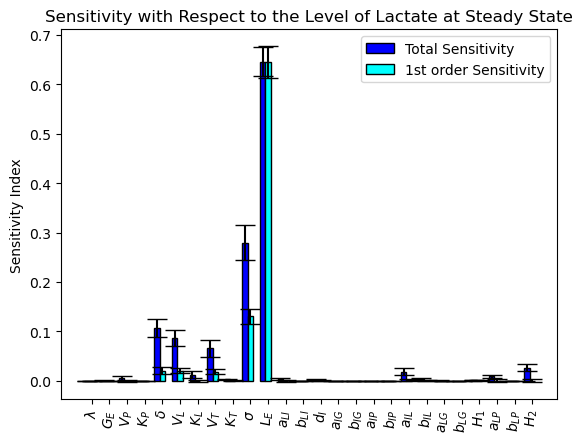

In [12]:
 # Si.get('S1') # returns array with values for S1    
A = Si_lactate.get('S1')
# change array to list for plotting
S1_values = A.tolist() # list of S1 values
# get ST values
B = Si_lactate.get('ST')
# change array to list for plotting
ST_values = B.tolist()
 # get confidence intervals for ST
C = Si_lactate.get('ST_conf')
# change array to list for plotting
STconf_values = C.tolist()
# get confidence intervals for S1
D = Si_lactate.get('S1_conf')
# change array to list for plotting
S1conf_values = D.tolist()
 
 # width of the bars
barWidth = 0.3
 
# Choose the height of the blue bars-- ST
bars1 = ST_values
 
# Choose the height of the cyan bars-- S1
bars2 = S1_values
 
# Choose the height of the error bars (bars1)-- CI for ST
yer1 = STconf_values
# Choose the height of the error bars (bars2)-- CI for S1
yer2 = S1conf_values
 
# The x position of bars
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

f = plt.figure()
 
# Create blue bars
plt.bar(r1, bars1, width = barWidth, color = 'blue', edgecolor = 'black', yerr=yer1, capsize=7, label='Total Sensitivity')
 
# Create cyan bars
plt.bar(r2, bars2, width = barWidth, color = 'cyan', edgecolor = 'black', yerr=yer2, capsize=7, label='1st order Sensitivity')
 
## general layout

plt.xticks([r + barWidth for r in range(len(bars1))], ['$\lambda$', '$G_E$', '$V_P$', '$K_P$', '$\delta$', '$V_L$', '$K_L$',
                                                       '$V_T$', '$K_T$', '$\sigma$', '$L_E$', '$a_{LI}$', '$b_{LI}$', '$d_I$',
                                                       '$a_{IG}$', '$b_{IG}$', '$a_{IP}$', '$b_{IP}$', '$a_{IL}$', '$b_{IL}$', '$a_{LG}$', '$b_{LG}$',
                                                       '$H_1$', '$a_{LP}$', '$b_{LP}$', '$H_2$'],rotation='vertical')
plt.ylabel('Sensitivity Index')
plt.legend()
plt.title('Sensitivity with Respect to the Level of Lactate at Steady State') 


# view and save figure (saving will allow you to put into your paper)
plt.show()


In [13]:
f.savefig("GSAmicrogliaLactate10-24.pdf")

### Perform Analysis for Inflammation

In [14]:
# perform analysis
# sobol.analyze will compute first, second, and total-order indices.
# Si is a Python dictionary with the keys "S1", "S2", "ST", "S1_conf", "S2_conf", and "ST_conf

Si_inflam = sobol.analyze(problem, Yinflam)
# see results on console for 1st order and total sensitivities
print(Si_inflam['S1'])  
print(Si_inflam['ST'])

[ 2.13517082e-07 -2.68055396e-05 -4.38621155e-05  9.91954875e-06
 -9.14110498e-05  1.04423611e-04  7.17736425e-05  8.23386583e-05
  2.10007136e-05 -8.16788384e-05  4.60426564e-04  7.75293321e-02
  1.92565815e-04  7.27572715e-01 -1.61154950e-07 -8.06261668e-09
 -7.80471040e-06  1.53418577e-08 -3.72703883e-06  5.30971842e-07
  3.78101072e-06  1.61571983e-06  2.43245376e-05 -1.94269641e-06
 -3.12570746e-06  4.94741201e-05]
[2.77134085e-09 2.46025533e-06 1.53213225e-05 7.40641786e-07
 2.11656694e-04 3.37344801e-04 1.15665349e-04 1.51536696e-04
 6.55647637e-06 2.45021820e-04 5.12582857e-03 2.94861370e-01
 2.43785512e-03 9.84366461e-01 7.65694247e-10 1.11799659e-11
 2.20431586e-06 2.11933325e-08 1.73689145e-06 1.00469627e-08
 8.90735528e-07 5.95977147e-08 4.70335420e-06 1.18320314e-05
 6.95778996e-07 1.86428453e-04]


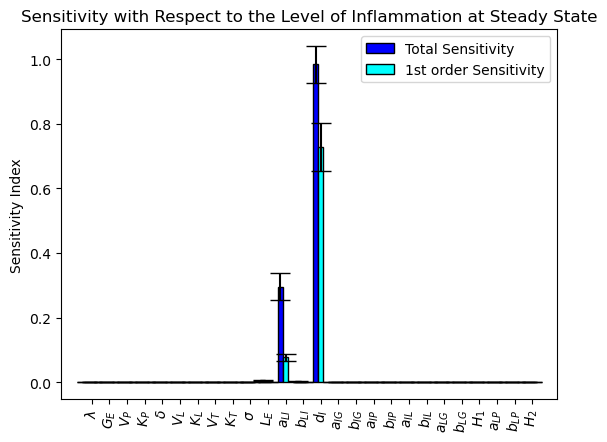

In [15]:
 # Si.get('S1') # returns array with values for S1    
A = Si_inflam.get('S1')
# change array to list for plotting
S1_values = A.tolist() # list of S1 values
# get ST values
B = Si_inflam.get('ST')
# change array to list for plotting
ST_values = B.tolist()
 # get confidence intervals for ST
C = Si_inflam.get('ST_conf')
# change array to list for plotting
STconf_values = C.tolist()
# get confidence intervals for S1
D = Si_inflam.get('S1_conf')
# change array to list for plotting
S1conf_values = D.tolist()
 
 # width of the bars
barWidth = 0.3
 
# Choose the height of the blue bars-- ST
bars1 = ST_values
 
# Choose the height of the cyan bars-- S1
bars2 = S1_values
 
# Choose the height of the error bars (bars1)-- CI for ST
yer1 = STconf_values
# Choose the height of the error bars (bars2)-- CI for S1
yer2 = S1conf_values
 
# The x position of bars
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

f = plt.figure()
 
# Create blue bars
plt.bar(r1, bars1, width = barWidth, color = 'blue', edgecolor = 'black', yerr=yer1, capsize=7, label='Total Sensitivity')
 
# Create cyan bars
plt.bar(r2, bars2, width = barWidth, color = 'cyan', edgecolor = 'black', yerr=yer2, capsize=7, label='1st order Sensitivity')
 
## general layout

plt.xticks([r + barWidth for r in range(len(bars1))], ['$\lambda$', '$G_E$', '$V_P$', '$K_P$', '$\delta$', '$V_L$', '$K_L$',
                                                       '$V_T$', '$K_T$', '$\sigma$', '$L_E$', '$a_{LI}$', '$b_{LI}$', '$d_I$',
                                                       '$a_{IG}$', '$b_{IG}$', '$a_{IP}$', '$b_{IP}$', '$a_{IL}$', '$b_{IL}$', '$a_{LG}$', '$b_{LG}$',
                                                       '$H_1$', '$a_{LP}$', '$b_{LP}$', '$H_2$'],rotation='vertical')
plt.ylabel('Sensitivity Index')
plt.legend()
plt.title('Sensitivity with Respect to the Level of Inflammation at Steady State') 

# view and save figure (saving will allow you to put into your paper)
plt.show()


In [16]:
f.savefig("GSAmicrogliaInflammation10-24.pdf")